In [1]:
using LinearAlgebra
using Random
using Flux
using Distributions
using OneHotArrays

In [2]:
mutable struct RNNwaveFn
    Ns::Int #system size
    seed
    N_hid::Int # width of the hidden state 
    N_st::Int # number of states in sigle site
    model

    Nb::Int # number of sample
    sample::Matrix{Int}
    log_prob::Vector{Float64}
    s0::Matrix{Float32}
end


In [3]:
function set_RNN(Ns0::Int, s0::Int, N_hid0::Int, N_st0::Int, Nb0::Int)
    ss = MersenneTwister(s0)
    model = Chain(LSTM(N_st0 => N_hid0),Dense(N_hid0 => N_st0), softmax)
    #model = Chain(LSTM(N_st0 => N_hid0; init=Flux.glorot_normal(s0)),Dense(N_hid0 => N_st0; init=Flux.randn32(ss)), softmax)
    sample = rand(ss, 1:N_st0, Nb0, Ns0)
    log_prob = zeros(Float64, Nb0)
    sig0 = zeros(Float32, Ns0, N_st0)

    return Ns0, ss, N_hid0, N_st0, model, Nb0, sample, log_prob, sig0
end


set_RNN (generic function with 1 method)

In [4]:
function get_sample!(rnn::RNNwaveFn)
    for b in 1:rnn.Nb
        #rnn_state = zeros(Float32, rnn.N_hid)
        Flux.reset!(rnn.model)
        for i in 1:rnn.Ns
            prob = rnn.model(rnn.s0[i,:])
            rnn.sample[b, i] = rand(Categorical(prob))
            rnn.log_prob[b] += log(prob[rnn.sample[b, i]])
        end
    end
end
        

get_sample! (generic function with 1 method)

In [5]:
struct Ham
    Nst::Int
    Jz::Float64
    Bx::Float64
    Hl::Matrix{ComplexF64}
    HB::Matrix{ComplexF64}
end

function set_Ham(Jz::Float64, Bx::Float64)
    Nst::Int = 2
    Hl::Matrix{ComplexF64} = [Jz 0.0; 0.0 -Jz]
    HB::Matrix{ComplexF64} = [0.0 Bx; Bx 0.0]
    return Nst, Jz, Bx, Hl, HB
end

set_Ham (generic function with 1 method)

In [6]:
function calc_local(H::Ham, R::RNNwaveFn)
    E_l = zeros(Float64, R.Nb)
    for b in 1:R.Nb
        for s in 1:R.Ns-1
            st1 = onehot(Int, 1:H.Nst, R.sample[b,s])
            st2 = onehot(Int, 1:H.Nst, R.sample[b,s+1])
            E_l[b] += real(st1' * H.Hl * st2)
            #=
            if(H.Bx != 0)
                for bp in b+1:R.Nb
                    st3 = onehot(Int, 1:H.Nst, R.sample[bp,s])
                    E_l[b] += real(s1' * H.HB * s3 + s3' * H.HB * s1)
                end
            end
            =#
        end       
    end
    return E_l /(R.Ns)
end

calc_local (generic function with 1 method)

In [11]:
function calc_local2(H::Ham, R::RNNwaveFn)
    #E_l = zeros(Float64, R.Nb)
    c = 0.0
    for b in 1:R.Nb
        E_l = 0.0
        for s in 1:R.Ns-1
            st1 = onehot(Int, 1:H.Nst, R.sample[b,s])
            st2 = onehot(Int, 1:H.Nst, R.sample[b,s+1])
            E_l += real(st1' * H.Hl * st2)
            #=
            if(H.Bx != 0)
                for bp in b+1:R.Nb
                    st3 = onehot(Int, 1:H.Nst, R.sample[bp,s])
                    E_l[b] += real(s1' * H.HB * s3 + s3' * H.HB * s1)
                end
            end
            =#
        end
        c += R.log_prob[b] * E_l / R.Nb
    end
    return c /(R.Ns)
end

calc_local2 (generic function with 1 method)

In [20]:
function calc_local3(H::Ham, R::RNNwaveFn)
    #E_l = zeros(Float64, R.Nb)
    c = 0.0
    E_lm = 0.0
    for b in 1:R.Nb
        E_l = 0.0
        for s in 1:R.Ns-1
            st1 = onehot(Int, 1:H.Nst, R.sample[b,s])
            st2 = onehot(Int, 1:H.Nst, R.sample[b,s+1])
            E_l += real(st1' * H.Hl * st2)
            #=
            if(H.Bx != 0)
                for bp in b+1:R.Nb
                    st3 = onehot(Int, 1:H.Nst, R.sample[bp,s])
                    E_l[b] += real(s1' * H.HB * s3 + s3' * H.HB * s1)
                end
            end
            =#
        end
        E_lm += E_l / R.Nb
        c += R.log_prob[b] * E_l / R.Nb
    end
    c -= E_lm * sum(R.log_prob)
    return c /(R.Ns)
end

calc_local3 (generic function with 1 method)

In [7]:
function cost(H::Ham, R::RNNwaveFn)
    c = (R.log_prob' * calc_local(H, R))/R.Nb
    return c
end

cost (generic function with 1 method)

In [27]:
opt = ADAM(1e-4)
rnn = RNNwaveFn(set_RNN(20, 1234, 50, 2, 500)...)
H = Ham(set_Ham(1.0, 0.0)...)


Ham(2, 1.0, 0.0, ComplexF64[1.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im -1.0 + 0.0im], ComplexF64[0.0 + 0.0im 0.0 + 0.0im; 0.0 + 0.0im 0.0 + 0.0im])

In [28]:
it_n = 5000
el = zeros(Float64, it_n)
for it in 1:it_n
    get_sample!(rnn)
    l = 0.0
    grads = Flux.gradient(Flux.params(rnn.model)) do
        l = calc_local3(H, rnn)
    end
    el[it] = l
    Flux.Optimise.update!(opt, Flux.params(rnn.model), grads)
end

In [15]:
using Plots

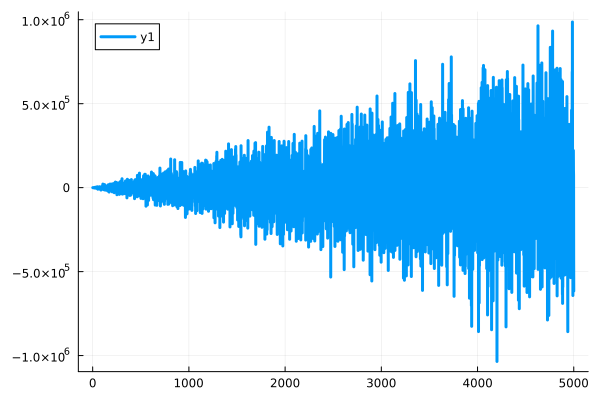

In [29]:
plot(el, width=3.0)

In [34]:
y = Multinomial(1, [0.1,0.1,0.8])
z = rand(y)
zz = onecold(z)

3

In [24]:
using StatsBase

In [33]:
using OneHotArrays

In [106]:
p = aweights([0.2, 0.8])
sample(1:2, p, 1)

1-element Vector{Int64}:
 2

In [109]:
A = Categorical([0.1999999, 0.8])
rand(A, 1)

LoadError: DomainError with [0.2, 0.8]:
Categorical: vector p is not a probability vector

In [74]:
logpdf(A,1)

-1.6094379124341003